In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from PIL import Image
import os
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath("../.."))
import tensorflow_util.util as util_tf

sys.path.append(os.environ['DATASETS_PATH'])
from mnist.mnist import get_mnist

In [2]:
#create training data

In [3]:
# folder = "./bmw10_release/bmw10_ims/"

# Npixels = 25
# Nchannels = 3

# data = []

# for d in os.listdir(folder):
#     for f in os.listdir(folder+d):
#         img = Image.open(folder+d+'/'+f)
        
#         img = img.resize((Npixels, Npixels))
        
#         data.append(np.asarray(img))
        
# data = np.asarray(data)
# print data.shape

# NUM_DATA = data.shape[0]


datasets = get_mnist()
data, _ = datasets[0]
print data.shape
NUM_DATA = data.shape[0]

Npixels=28
Nchannels=1
data = data.reshape((NUM_DATA, Npixels, Npixels,1))
print data.shape
print data[0,:].shape

(50000, 784)
(50000, 28, 28, 1)
(28, 28, 1)


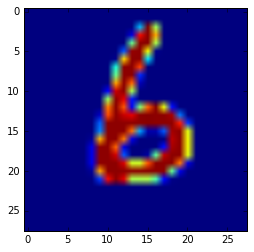

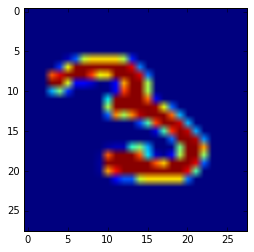

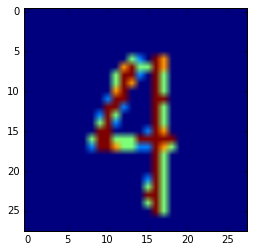

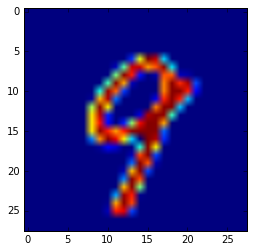

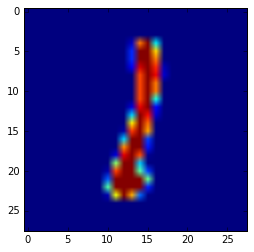

In [4]:
#plot some random images
Num_images_to_plot = 5
for i in range(0,Num_images_to_plot):
    index = np.random.randint(NUM_DATA)
    
    plt.imshow(data[index,:,:,0])
    plt.show()

In [5]:
#normalize data

In [6]:
means = np.mean(data, axis=(0,1,2))
stdevs = np.std(data,axis=(0,1,2))

print means
print stdevs

data_norm = (data-means)/stdevs

print np.mean(data_norm, axis=(0,1,2))
print np.std(data_norm,axis=(0,1,2))

[ 0.13044983]
[ 0.30728981]
[ -3.16381460e-07]
[ 0.99999934]


In [7]:
#define network structure
NBATCH = 100
W_init = 0.001
NOISE_DIM = 50
G_Nunits1 = (Npixels-4)**2


In [8]:
x = tf.placeholder(tf.float32, shape=(NBATCH,Npixels,Npixels,Nchannels))
z = tf.placeholder(tf.float32, shape=(NBATCH,NOISE_DIM))

In [9]:
#generator network

In [10]:
G_hidden1, G_w1, G_b1 = util_tf.fc_weights(z, NOISE_DIM, G_Nunits1, std=W_init)
G_hidden1 = tf.nn.relu(G_hidden1)

G_hidden1 = tf.reshape(G_hidden1, [NBATCH, Npixels-4, Npixels-4, 1])

G_hidden2, G_w2, G_b2 = util_tf.deconv2d_3x3_weights(
G_hidden1,
outshape=[NBATCH, Npixels-2, Npixels-2, 32],
out_channels=32,
Nfilters=1,
std=W_init)

G_hidden2 = tf.nn.relu(G_hidden2)

G_out, G_w3, G_b3 = util_tf.deconv2d_3x3_weights(
G_hidden2,
outshape=[NBATCH, Npixels, Npixels, Nchannels],
out_channels=Nchannels,
Nfilters=32,
std=W_init)

In [11]:
#Discriminator network
Nfilters = 32
Conv_Shape = 3
strides = [1,1,1,1]
p = 0.5

In [12]:
D_w1 = tf.Variable(
    tf.random_normal(shape=(Conv_Shape,Conv_Shape,Nchannels,Nfilters),
                    stddev=W_init
                    )
)

D_b1 = tf.Variable(
    tf.zeros(shape=[Nfilters])
)

D_w2 = tf.Variable(
    tf.random_normal(shape=(Conv_Shape,Conv_Shape,Nfilters,Nfilters),
                    stddev=W_init
                    )
)

D_b2 = tf.Variable(
    tf.zeros(shape=[Nfilters])
)

D_w3 = tf.Variable(
    tf.random_normal(shape=(Nfilters*Npixels**2,1),
                    stddev=W_init
                    )
)

D_b3 = tf.Variable(
    tf.zeros(shape=(1,1))
)

In [13]:
#pass real data through discriminator
def Pass_through_discriminator(x_in):
    D_real_out1 = util_tf.conv2d_3x3(x_in, D_w1, D_b1, padding="SAME")
    D_real_out1 = tf.nn.relu(D_real_out1)
    D_real_out1 = tf.nn.dropout(D_real_out1, keep_prob=p)
    
    D_real_out2 = util_tf.conv2d_3x3(D_real_out1, D_w2, D_b2, padding="SAME")
    D_real_out2 = tf.nn.relu(D_real_out2)
    D_real_out2 = tf.nn.dropout(D_real_out2, keep_prob=p)

    D_real_out3 = tf.reshape(D_real_out2,[NBATCH,-1])
    D_real_out3 = util_tf.fc(D_real_out3,D_w3, D_b3)
    D_real_out3 = tf.nn.sigmoid(D_real_out3)
    
    return D_real_out3

In [14]:
real_out = Pass_through_discriminator(x)

fake_out = Pass_through_discriminator(G_out)

In [15]:
#loss functions

In [16]:
var_reg = 0.0

D_loss = -tf.reduce_mean(tf.log(real_out)) -\
tf.reduce_mean(tf.log(1-fake_out))

#fake_var = tf.reduce_mean(tf.square(G_out-tf.reduce_mean(G_out)))

#var_loss = tf.square(fake_var-1)
var_loss = 0.0
G_loss1 = -tf.reduce_mean(tf.log(fake_out)) + var_reg*var_loss

G_loss2 = tf.reduce_mean(tf.log(1-fake_out)) + var_reg*var_loss

In [17]:
#set up optimization
lrG = 1e-4
lrD = 1e-4

In [18]:
optG = tf.train.AdamOptimizer(lrG)
optD = tf.train.AdamOptimizer(lrD)
D_train = optD.minimize(D_loss, var_list=[D_w1,D_b1,D_w2,D_b2,D_w3,D_b3])

G_train1 = optG.minimize(G_loss1, var_list=[G_w1,G_b1,G_w2,G_b2,G_w3,G_b3])

G_train2 = optG.minimize(G_loss2, var_list=[G_w1,G_b1,G_w2,G_b2,G_w3,G_b3])

In [19]:
#set up session and initialize
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

In [54]:
#set up training loop
Niter1 = 10000
Niter2 = 10000
kd = 1
kg = 1
print_step = 1000

def get_batch(xdata, nbatch):
    N = xdata.shape[0]
    inds = np.random.choice(N, size=nbatch, replace=False)
    xret = xdata[inds,:]

    return xret

In [51]:
#some tests
x_batch = get_batch(data_norm, NBATCH)
z_batch = np.random.rand(NBATCH,NOISE_DIM)

gout = sess.run(G_out, feed_dict={z:z_batch})
print gout.shape
print gout[0,0,:,:]
print sess.run(G_loss1, feed_dict={z:z_batch})
print sess.run(G_loss2, feed_dict={z:z_batch})

dout_real = sess.run(real_out, feed_dict={x:x_batch})
dout_fake = sess.run(fake_out, feed_dict={z:z_batch})
print dout_real.shape
print dout_fake.shape
print dout_real[0]
print dout_fake[0]
print sess.run(D_loss, feed_dict={x:x_batch,z:z_batch})

(100, 28, 28, 1)
[[-0.02482961]
 [-0.02482961]
 [ 0.66629547]
 [-0.02482961]
 [-0.02482961]
 [-0.02482961]
 [-0.02482961]
 [-0.02482961]
 [ 1.40044177]
 [ 1.31215167]
 [ 1.81786621]
 [ 0.53708535]
 [ 1.65934658]
 [-0.02482961]
 [-0.02482961]
 [-0.02482961]
 [-0.02482961]
 [ 1.54519737]
 [-0.02482961]
 [-0.02482961]
 [ 1.16387582]
 [-0.02482961]
 [ 1.1711266 ]
 [-0.02482961]
 [ 0.61903381]
 [-0.02482961]
 [-0.02482961]
 [ 1.38482082]]
0.0897778
-2.46428
(100, 1)
(100, 1)
[ 0.91990429]
[ 0.92738682]
4.9779


In [73]:
#training loop 1
for step in xrange(Niter1+1):

    for i in range(0,kd):    
        x_batch = get_batch(data_norm, NBATCH)
        z_batch = np.random.rand(NBATCH,NOISE_DIM)
        
        sess.run(D_train,feed_dict={x:x_batch,z:z_batch})
    
    for i in range(0,kg):
        z_batch = np.random.rand(NBATCH,NOISE_DIM)
        
        sess.run(G_train1, feed_dict={z:z_batch})
        
    if step % print_step == 0:
        dl=sess.run(D_loss,feed_dict={x:x_batch,z:z_batch})
        gl=sess.run(G_loss1,feed_dict={z:z_batch})

        print "Discriminator loss: ", dl, ", Generator loss: ", gl

Discriminator loss:  1.73965 , Generator loss:  0.786422
Discriminator loss:  1.36273 , Generator loss:  3.01689
Discriminator loss:  0.983896 , Generator loss:  6.69252
Discriminator loss:  7.49468 , Generator loss:  13.8959
Discriminator loss:  2.39325 , Generator loss:  8.73296
Discriminator loss:  5.37212 , Generator loss:  9.367
Discriminator loss:  5.39394 , Generator loss:  5.721
Discriminator loss:  1.02031 , Generator loss:  2.8048
Discriminator loss:  0.677954 , Generator loss:  4.67936
Discriminator loss:  0.787168 , Generator loss:  5.2846
Discriminator loss:  1.79569 , Generator loss:  6.37965


In [57]:
#training loop 2
for step in xrange(Niter2+1):
    
    for i in range(0,kd):
        x_batch = get_batch(data_norm, NBATCH)
        z_batch = np.random.rand(NBATCH,NOISE_DIM)
    
        sess.run(D_train,feed_dict={x:x_batch,z:z_batch})
    
    for i in range(0,kg):
        z_batch = np.random.rand(NBATCH,NOISE_DIM)
        sess.run(G_train2, feed_dict={z:z_batch})
        
    if step % print_step == 0:
        dl=sess.run(D_loss,feed_dict={x:x_batch,z:z_batch})
        gl=sess.run(G_loss2,feed_dict={z:z_batch})

        print "Discriminator loss: ", dl, ", Generator loss: ", gl

Discriminator loss:  1.70143 , Generator loss:  -0.0332729
Discriminator loss:  nan , Generator loss:  nan


KeyboardInterrupt: 

In [26]:
#generate some cars

(100, 28, 28, 1)
0.518046
[ 0.30728981]
[ 0.13044983]


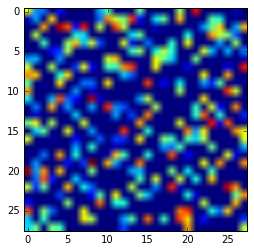

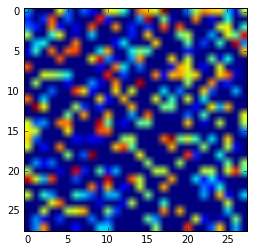

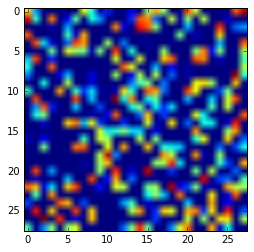

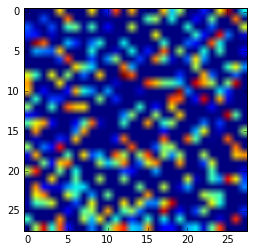

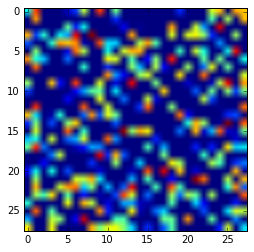

In [56]:
z_batch = np.random.rand(NBATCH,NOISE_DIM)

gen_data = sess.run(G_out, feed_dict={z:z_batch})
print gen_data.shape
print np.std(gen_data)
#plot some random images
print stdevs
print means
Num_images_to_plot = 5
for i in range(0,Num_images_to_plot):
    index = np.random.randint(NBATCH)
    
    plt.imshow((gen_data[index,:,:,0]*stdevs)+means)
    #plt.imshow(gen_data[index,:,:,0])
    plt.show()